In [6]:
# Libraries
# ======================================================================================
import sys
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import  HistGradientBoostingRegressor
import skforecast
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from sklearn.model_selection import train_test_split
import importlib
import seaborn as sns
warnings.filterwarnings('once')

print(f"Version skforecasy: {skforecast.__version__}")
print(f"Version scikit-learn: {sklearn.__version__}")

Version skforecasy: 0.13.0
Version scikit-learn: 1.5.1


In [7]:
# read in data
survey_file = '/Users/htr365/no_icloud/quantified_self_all/data/survey_data/pre_processed_survey_features.csv'
df = pd.read_csv(survey_file,index_col=0)

In [8]:
# filter a person
df = df[df['person']=='Amanda']
df.index = df['date']

In [9]:
# exclude two days at the beginning (due to long break inbetween)
df = df[df['date']>='2024-07-08']


In [10]:
# set index and frequency
df.index =  pd.to_datetime(df['date'])
df = df.sort_index()
# get complete list of dates
all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
# Reindex the DataFrame to include all dates in the range
df = df.reindex(all_dates)
df = df.fillna(method='ffill')  # Forward fill missing values
# set frequency to daily
df.index.freq = 'D'

/var/folders/m2/yy15wc4d3zqdtsvvvggmkn780000gp/T/ipykernel_59468/3437487274.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Forward fill missing values


In [11]:
# define variables of interest and get human prediction
human_prediction = df[['fatigue_expected','muscles_sore_expected','muscles_tired_expected']]
pred_variables = ['cis_subjective_fatigue', 'hooper_muscles_sore','extra_muscles_tired']
variables_of_interest = ['cis_subjective_fatigue','cis_concentration','cis_motivation','cis_physical_activity',
                         'hooper_fatigue_level','hooper_stress_level', 'hooper_muscles_sore','hooper_sleep_quality',
                         'extra_muscles_tired','step_count','sleep_time','alcohol']

<Figure size 640x480 with 0 Axes>

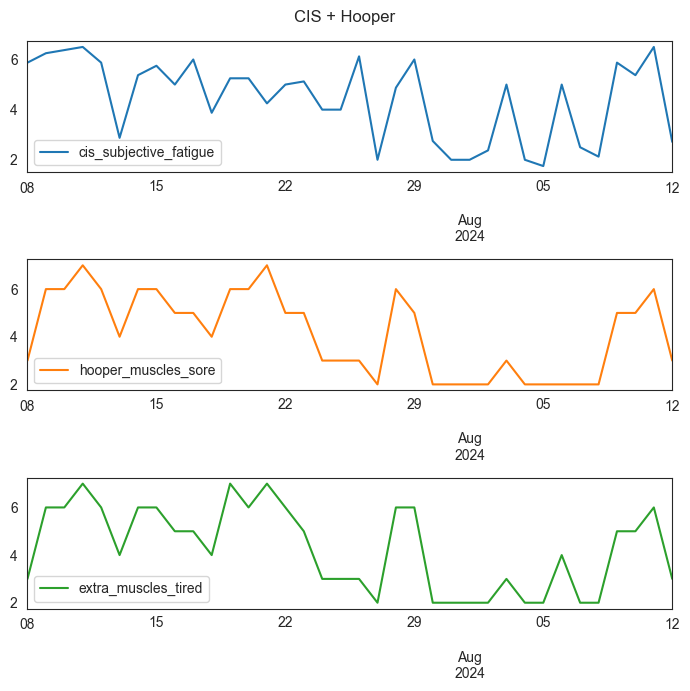

In [12]:
# Plot time series
# ======================================================================================
sns.set_style("white")
sns.despine()
fig, axs = plt.subplots(len(pred_variables), 1, figsize=(7, 7), sharex=False)
df[pred_variables].plot(
    legend   = True,
    subplots = True, 
    title    = 'CIS + Hooper',
    ax       = axs, 
)
#for ax in axs:
  #  ax.axvline(pd.to_datetime(end_train) , color='white', linestyle='--', linewidth=1.5)
  #  ax.axvline(pd.to_datetime(end_val ), color='white', linestyle='--', linewidth=1.5)
fig.tight_layout()
plt.show()

In [13]:
data= df[pred_variables]

In [14]:
end_train = round(len(data.index)*0.8)
end_train = data.index[end_train]

end_val = round(len(data.index)*0.9)
end_val = data.index[end_val]

In [15]:
data_train = data.loc[:end_train, :].copy()
data_val   = data.loc[end_train:end_val, :].copy()
data_test  = data.loc[end_val:, :].copy()
print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2024-07-08 00:00:00 --- 2024-08-06 00:00:00  (n=30)
Validation dates : 2024-08-06 00:00:00 --- 2024-08-09 00:00:00  (n=4)
Test dates       : 2024-08-09 00:00:00 --- 2024-08-12 00:00:00  (n=4)


In [16]:
# Function to give 0 weights to imputed data
# see: https://cienciadedatos.net/documentos/py46-forecasting-time-series-missing-values
def custom_weights(index):
    """
    Return 0 if index is in any gap.
    """
    gaps = [['2024-07-25','2024-08-01']]
    weights = np.where(index.isin(gaps), 0, 1)

    return weights

# Evaluate Human Prediction

In [227]:
# create lead variable
human_prediction['muscles_sore_prediction']= human_prediction['muscles_sore_expected'].shift(1)
human_prediction['muscles_tired_prediction']= human_prediction['muscles_tired_expected'].shift(1)
human_prediction['fatigue_prediction']= human_prediction['fatigue_expected'].shift(1)

/var/folders/m2/yy15wc4d3zqdtsvvvggmkn780000gp/T/ipykernel_1474/758890188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_prediction['muscles_sore_prediction']= human_prediction['muscles_sore_expected'].shift(1)
/var/folders/m2/yy15wc4d3zqdtsvvvggmkn780000gp/T/ipykernel_1474/758890188.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_prediction['muscles_tired_prediction']= human_prediction['muscles_tired_expected'].shift(1)
/var/folders/m2/yy15wc4d3zqdtsvvvggmkn780000gp/T/ipykernel_1474/75

In [228]:
# merge prediction and true values
human_prediction = human_prediction.merge(df[pred_variables],how='left',left_index=True, right_index=True)


In [229]:

# calculate difference
human_prediction['fatigue_diff'] = human_prediction[pred_variables[0]]-human_prediction['fatigue_prediction']
human_prediction['sore_diff'] = human_prediction[pred_variables[1]]-human_prediction['muscles_sore_prediction']
human_prediction['tired_diff'] = human_prediction[pred_variables[2]]-human_prediction['muscles_tired_prediction']

In [230]:
human_prediction['date'] =human_prediction.index

In [231]:
# get overall MAE
print("MAE Fatigue: ", np.mean(np.abs(human_prediction['fatigue_diff'])))
print("MAE Sore: ", np.mean(np.abs(human_prediction['sore_diff'])))
print("MAE Tired: ", np.mean(np.abs(human_prediction['tired_diff'])))

MAE Fatigue:  1.6581632653061225
MAE Sore:  1.1142857142857143
MAE Tired:  1.1714285714285715


In [264]:
# get test MAE
print("MAE Fatigue: ", np.mean(np.abs(human_prediction[end_train:]['fatigue_diff'])))
print("MAE Sore: ", np.mean(np.abs(human_prediction[end_train:]['sore_diff'])))
print("MAE Tired: ", np.mean(np.abs(human_prediction[end_train:]['tired_diff'])))

MAE Fatigue:  2.0943877551020407
MAE Sore:  1.2857142857142858
MAE Tired:  1.5714285714285714


In [220]:

#plt.figure(figsize=(12, 8))

# Plot Series 1 and Series 2
#sns.lineplot(data=human_prediction, x='date', y='fatigue_diff',  markers=True)
#sns.lineplot(data=human_prediction, x='date', y='sore_diff',  markers=True, linestyle='--')
#sns.lineplot(data=human_prediction, x='date', y='tired_diff',  markers=True, linestyle='--')


# Fill the area between the curve and the x-axis (y=0)
#plt.fill_between(human_prediction['date'], human_prediction['fatigue_diff'], 0, where=(human_prediction['fatigue_diff'] >= 0), color='skyblue', alpha=0.4)
#plt.fill_between(human_prediction['date'], human_prediction['fatigue_diff'], 0, where=(human_prediction['fatigue_diff'] < 0), color='lightcoral', alpha=0.4)

# Plot Differences
#sns.lineplot(data=df, x='Date', y='Difference', hue='Pair', style='Pair', markers=True, linestyle=':', linewidth=2)


# Always predict mean

In [270]:
print("Fatigue MAE when predicting mean:", np.mean(np.abs(data['cis_subjective_fatigue'][end_train:] - data['cis_subjective_fatigue'].mean())))
print("Tired MAE when predicting mean:", np.mean(np.abs(data['extra_muscles_tired'][end_train:] - data['extra_muscles_tired'].mean())))
print("Sore MAE when predicting mean:", np.mean(np.abs(data['hooper_muscles_sore'][end_train:] - data['hooper_muscles_sore'].mean())))

Fatigue MAE when predicting mean: 1.5682397959183674
Tired MAE when predicting mean: 1.3253968253968256
Sore MAE when predicting mean: 1.5912698412698414


# Random Forest Predictor
Adapted from https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn

In [261]:
from sklearn.ensemble import RandomForestRegressor

items = []
rf_mae_values = []
rf_predictions = {}
# Backtest forecaster
# ==============================================================================
forecaster_random_forest = ForecasterAutoreg(
                  regressor = RandomForestRegressor(random_state=123),
                  lags      = 5,
                  weight_func=custom_weights
             )
for i, item in enumerate(data.columns):
     print(item)
     rf_metric, rf_predictions_backtest = backtesting_forecaster(
                                        forecaster = forecaster_random_forest,
                                        y          = data[item],
                                        initial_train_size =len(data_train),
                                        fixed_train_size   = False,
                                        steps      = 1,
                                        metric     = 'mean_absolute_error',
                                        refit      = False,
                                        verbose    = True
                                   )
     items.append(item)
     rf_mae_values.append(rf_metric)
     rf_predictions[item] = rf_predictions_backtest

# Results
rf_uni_series_mae = pd.Series(
                     data  = rf_mae_values,
                     index = items,
                     name  = 'uni_series_mae'
                 );

cis_subjective_fatigue
Information of backtesting process
----------------------------------
Number of observations used for initial training: 30
Number of observations used for backtesting: 6
    Number of folds: 6
    Number of steps per fold: 1
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-07 00:00:00 -- 2024-08-07 00:00:00  (n=1)
Fold: 1
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-08 00:00:00 -- 2024-08-08 00:00:00  (n=1)
Fold: 2
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-09 00:00:00 -- 2024-08-09 00:00:00  (n=1)
Fold: 3
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-10 00:00:00 -- 2024-08-10 00:00:00  (n=1)
Fold: 4
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-11 00

/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/6 [00:00<?, ?it/s]

hooper_muscles_sore
Information of backtesting process
----------------------------------
Number of observations used for initial training: 30
Number of observations used for backtesting: 6
    Number of folds: 6
    Number of steps per fold: 1
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-07 00:00:00 -- 2024-08-07 00:00:00  (n=1)
Fold: 1
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-08 00:00:00 -- 2024-08-08 00:00:00  (n=1)
Fold: 2
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-09 00:00:00 -- 2024-08-09 00:00:00  (n=1)
Fold: 3
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-10 00:00:00 -- 2024-08-10 00:00:00  (n=1)
Fold: 4
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-11 00:00

/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/6 [00:00<?, ?it/s]

extra_muscles_tired
Information of backtesting process
----------------------------------
Number of observations used for initial training: 30
Number of observations used for backtesting: 6
    Number of folds: 6
    Number of steps per fold: 1
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-07 00:00:00 -- 2024-08-07 00:00:00  (n=1)
Fold: 1
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-08 00:00:00 -- 2024-08-08 00:00:00  (n=1)
Fold: 2
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-09 00:00:00 -- 2024-08-09 00:00:00  (n=1)
Fold: 3
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-10 00:00:00 -- 2024-08-10 00:00:00  (n=1)
Fold: 4
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-11 00:00

/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/6 [00:00<?, ?it/s]

In [262]:
rf_uni_series_mae

cis_subjective_fatigue    1.586369
hooper_muscles_sore       1.663333
extra_muscles_tired       1.551667
Name: uni_series_mae, dtype: float64

In [263]:
rf_predictions

{'cis_subjective_fatigue':                pred
 2024-08-07  2.97000
 2024-08-08  2.62500
 2024-08-09  2.86750
 2024-08-10  2.90750
 2024-08-11  3.60125
 2024-08-12  2.88875,
 'hooper_muscles_sore':             pred
 2024-08-07  2.21
 2024-08-08  2.05
 2024-08-09  2.04
 2024-08-10  2.88
 2024-08-11  2.93
 2024-08-12  4.57,
 'extra_muscles_tired':             pred
 2024-08-07  3.25
 2024-08-08  2.33
 2024-08-09  3.66
 2024-08-10  3.23
 2024-08-11  3.48
 2024-08-12  5.10}

# Gradient Boosting Forecaster

In [285]:
items = []
gb_mae_values = []
gb_predictions = {}
# Define forecaster
forecaster_gradient_boost = ForecasterAutoreg(
                    regressor     = HistGradientBoostingRegressor(random_state=8523),
                    lags          = 5,
                    transformer_y = StandardScaler()
                 )
for i, item in enumerate(tqdm(data.columns)):

     gb_metric, gb_predictions_backtest = backtesting_forecaster(
                                        forecaster = forecaster_gradient_boost,
                                        y          = data[item],
                                        initial_train_size = len(data.loc[:end_train]),
                                        fixed_train_size   = False,
                                        steps      = 1,
                                        metric     = 'mean_absolute_error',
                                        refit      = False,
                                        verbose    = True
                                   )

     items.append(item)
     gb_mae_values.append(gb_metric)
     gb_predictions[item] = gb_predictions_backtest

# Results
gb_uni_series_mae = pd.Series(
                     data  = gb_mae_values,
                     index = items,
                     name  = 'gb_uni_series_mae')

/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/3 [00:00<?, ?it/s]

/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


Information of backtesting process
----------------------------------
Number of observations used for initial training: 30
Number of observations used for backtesting: 6
    Number of folds: 6
    Number of steps per fold: 1
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-07 00:00:00 -- 2024-08-07 00:00:00  (n=1)
Fold: 1
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-08 00:00:00 -- 2024-08-08 00:00:00  (n=1)
Fold: 2
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-09 00:00:00 -- 2024-08-09 00:00:00  (n=1)
Fold: 3
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-10 00:00:00 -- 2024-08-10 00:00:00  (n=1)
Fold: 4
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-11 00:00:00 -- 2024-08-11 00

  0%|          | 0/6 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 30
Number of observations used for backtesting: 6
    Number of folds: 6
    Number of steps per fold: 1
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-07 00:00:00 -- 2024-08-07 00:00:00  (n=1)
Fold: 1
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-08 00:00:00 -- 2024-08-08 00:00:00  (n=1)
Fold: 2
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-09 00:00:00 -- 2024-08-09 00:00:00  (n=1)
Fold: 3
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-10 00:00:00 -- 2024-08-10 00:00:00  (n=1)
Fold: 4
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-11 00:00:00 -- 2024-08-11 00

/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/6 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 30
Number of observations used for backtesting: 6
    Number of folds: 6
    Number of steps per fold: 1
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-07 00:00:00 -- 2024-08-07 00:00:00  (n=1)
Fold: 1
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-08 00:00:00 -- 2024-08-08 00:00:00  (n=1)
Fold: 2
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-09 00:00:00 -- 2024-08-09 00:00:00  (n=1)
Fold: 3
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-10 00:00:00 -- 2024-08-10 00:00:00  (n=1)
Fold: 4
    Training:   2024-07-08 00:00:00 -- 2024-08-06 00:00:00  (n=30)
    Validation: 2024-08-11 00:00:00 -- 2024-08-11 00

/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/6 [00:00<?, ?it/s]

# Gradient Boosting Multiseries

In [286]:
data_all = df[variables_of_interest]

In [333]:
# Train and backtest a model for all items: ForecasterAutoregMultiSeries
# ======================================================================================
items = list(data_all.columns)

# Define forecaster
forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = HistGradientBoostingRegressor(random_state=8523),
                    lags               = 5,
                    encoding           = 'ordinal',
                    transformer_series = StandardScaler(),
                )
# Backtesting forecaster for all items
gb_multi_series_mae, gb_predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = data_all,
                                       levels             = items,
                                       steps              = 7,
                                       metric             = 'mean_absolute_error',
                                       initial_train_size = len(data_all.loc[:end_train]),
                                       refit              = False,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True 
                                    )
# Results
display(gb_multi_series_mae.head(3))
print('')
display(gb_predictions_ms.head(3))


/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,cis_subjective_fatigue,1.492931
1,cis_concentration,1.868084
2,cis_motivation,1.655402


,cis_subjective_fatigue,cis_concentration,cis_motivation,cis_physical_activity,hooper_fatigue_level,hooper_stress_level,hooper_muscles_sore,hooper_sleep_quality,extra_muscles_tired,step_count,sleep_time,alcohol
2024-08-07,2.717053,3.912596,5.266012,6.162228,2.697188,4.276713,2.461723,3.384443,3.411631,13808.515720,387.197093,1.068712
2024-08-08,3.148921,3.554428,3.566531,5.220216,3.101155,3.963654,2.039279,3.297461,1.753960,14238.203374,331.624497,1.313554
2024-08-09,4.523055,3.050033,4.341933,4.966300,4.936186,3.594972,2.118006,4.499978,3.426473,11218.468481,441.340850,0.507989


# Random Forest Multiseries

In [334]:
# Train and backtest a model for all items: ForecasterAutoregMultiSeries
# ======================================================================================
items = list(data_all.columns)

# Define forecaster
forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = RandomForestRegressor(random_state=123),
                    lags               = 5,
                    encoding           = 'ordinal',
                    transformer_series = StandardScaler(),
                )
# Backtesting forecaster for all items
rf_multi_series_mae, rf_predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = data_all,
                                       levels             = items,
                                       steps              = 7,
                                       metric             = 'mean_absolute_error',
                                       initial_train_size = len(data_all.loc[:end_train]),
                                       refit              = False,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True 
                                    )
# Results
display(rf_multi_series_mae.head(3))
print('')
display(rf_predictions_ms.head(3))


/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,cis_subjective_fatigue,1.445447
1,cis_concentration,1.685922
2,cis_motivation,1.732349


,cis_subjective_fatigue,cis_concentration,cis_motivation,cis_physical_activity,hooper_fatigue_level,hooper_stress_level,hooper_muscles_sore,hooper_sleep_quality,extra_muscles_tired,step_count,sleep_time,alcohol
2024-08-07,3.238180,3.785810,4.329633,5.465312,3.367594,4.812594,2.477733,3.586922,2.907143,12583.311579,434.718102,0.719292
2024-08-08,3.668398,4.284778,3.976697,4.579159,3.852658,4.226065,2.334719,3.680688,2.272221,11770.951765,413.190897,0.862312
2024-08-09,4.523722,3.261299,4.321836,4.959382,5.108454,3.714587,2.167787,4.644951,3.229110,9485.739548,433.285831,0.500389


# Combine and Compare

In [322]:
def prep_pred_dataframe(preds, model):
    preds_df = pd.concat(preds.values(), axis=1)
    preds_df.columns = preds.keys()
    preds_df = preds_df.reset_index().melt(id_vars='index', var_name='measurement', value_name='value')
    preds_df['model'] = model
    return preds_df

In [335]:
gb_ms_df = gb_predictions_ms[pred_variables].reset_index().melt(id_vars='index', var_name='measurement', value_name='value')
gb_ms_df['model'] = 'Gradient Boosting Multiseries'

rf_ms_df = rf_predictions_ms[pred_variables].reset_index().melt(id_vars='index', var_name='measurement', value_name='value')
rf_ms_df['model'] = 'Random Forest Multiseries'

In [336]:
gb_df = prep_pred_dataframe(gb_predictions,'Gradient Boosting')
rf_df = prep_pred_dataframe(rf_predictions,'Random Forest')

In [345]:
# get Human prediction
human_df = human_prediction[['fatigue_prediction','muscles_tired_prediction','muscles_sore_prediction']][end_train:].\
rename(columns={'fatigue_prediction':'cis_subjective_fatigue','muscles_tired_prediction':'extra_muscles_tired','muscles_sore_prediction':'hooper_muscles_sore'}).\
reset_index().melt(id_vars='index', var_name='measurement', value_name='value')
human_df['model'] = 'Human Prediction'

In [369]:
# get mean
mean_df = df[pred_variables][:end_train].mean()
mean_df = mean_df.rename('mean')
mean_df = pd.merge(gb_ms_df[['index','measurement']],mean_df,how='left',right_index=True, left_on='measurement')
mean_df['model'] ="Always predict Mean"
mean_df = mean_df.rename(columns={'mean':'value'})


In [371]:
all_predictions = pd.concat([gb_ms_df,rf_ms_df,gb_df,rf_df,human_df,mean_df])

# RNN

In [17]:
import os
os.environ["KERAS_BACKEND"] = "torch" # 'tensorflow', 'jax´ or 'torch'
import keras
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

if keras.__version__ > "3.0":
    if keras.backend.backend() == "tensorflow":
        import tensorflow
    elif keras.backend.backend() == "torch":
        import torch
    else:
        print("Backend not recognized. Please use 'tensorflow' or 'torch'.")

In [18]:
import skforecast
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries


In [31]:
os.environ['PYTORCH_ENABLE_MPS_FALLBACK']='1'

In [19]:
# Time series used in the training. Now, it is multiseries
series = variables_of_interest
levels = ["cis_subjective_fatigue"] 
lags = 32 
steps = 5 

data = df[series].copy()
data_train =df[:end_train][series].copy()
data_val = df[end_train:end_val][series].copy()
data_test = df[:end_val][series].copy()

model = create_and_compile_model(

    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.5.0
Using backend: torch
torch version: 2.2.2


/Users/htr365/opt/anaconda3/envs/scrape/lib/python3.9/site-packages/keras/src/backend/torch/linalg.py:53: UserWarning: The operator 'aten::linalg_qr.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch.linalg.qr(x, mode=mode)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32, 100)        │        45,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,909 (316.05 KB)

 Trainable params: 80,909 (316.05 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Forecaster creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    steps=steps,
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 4,  
        "batch_size": 3  
        "series_val": data_val,
    },
)
forecaster

In [ ]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

# OLD STUFF

In [76]:

def pred_to_df(predictions):
    combined_df= pd.DataFrame()

    # Loop through each key, value pair in the dictionary
    for key, df in predictions.items():
        # Rename the 'pred' column to the key value
        df = df.rename(columns={'pred': key})
        # Concatenate along columns
        if combined_df.empty:
            combined_df = df
        else:
            combined_df = pd.concat([combined_df, df], axis=1)
    return combined_df

In [77]:
rf_test_pred = pred_to_df(rf_predictions)
gb_test_pred = pred_to_df(gb_predictions)

In [78]:
var_outcome = 'cis_subjective_fatigue'#,'hooper_fatigue_level','extra_muscles_tired','hooper_muscles_sore']
human_pred = ['fatigue_expected','muscles_sore_expected','muscles_tired_expected']

In [79]:
dict_human = {'cis_subjective_fatigue':'fatigue_expected',
              'hooper_fatigue_level':'fatigue_expected',
              'extra_muscles_tired':'muscles_tired_expected',
              'hooper_muscles_sore':'muscles_sore_expected'}

In [80]:
dict_human.get(var_outcome)

'fatigue_expected'

In [97]:
data_test.index

DatetimeIndex(['2024-07-27', '2024-07-28', '2024-07-29'], dtype='datetime64[ns]', name='date', freq='D')

In [124]:
import datetime
data_human_pred = data[np.isin(data.index,data_test.index-datetime.timedelta(days=1))][dict_human.get(var_outcome)].rename('h_'+var_outcome)
data_human_pred.index = data_human_pred.index +datetime.timedelta(days=1)

In [125]:
results = pd.concat([rf_test_pred[var_outcome].rename('rf_'+var_outcome),
gb_test_pred[var_outcome].rename('gb_'+var_outcome),
data_human_pred],
axis=1)

results_diff = data_test[var_outcome]-results
results

,rf_cis_subjective_fatigue,gb_cis_subjective_fatigue,h_cis_subjective_fatigue
2024-07-26,4.917500,4.831731,NaN
2024-07-27,4.522500,4.831731,4.0
2024-07-28,4.845625,4.831731,7.0
2024-07-29,4.905625,4.831731,7.0


In [86]:
data_test.columns

Index(['person', 'date', 'cis_1', 'cis_2', 'cis_3', 'cis_4', 'cis_5', 'cis_6',
       'cis_7', 'cis_8', 'cis_9', 'cis_10', 'cis_11', 'cis_12', 'cis_13',
       'cis_14', 'cis_15', 'cis_16', 'cis_17', 'cis_18', 'cis_19', 'cis_20',
       'hooper_muscles_sore', 'extra_muscles_tired', 'hooper_sleep_quality',
       'hooper_fatigue_level', 'hooper_stress_level', 'sleep_hours',
       'coffee_count', 'physical_activity', 'step_count', 'alcohol',
       'fatigue_expected', 'muscles_sore_expected', 'muscles_tired_expected',
       'cis_subjective_fatigue', 'cis_concentration', 'cis_motivation',
       'cis_physical_activity', 'sleep_time', 'walking', 'cycling',
       'ball_sports', 'weight_lifting', 'running', 'yoga', 'HITT',
       'manual_labour', 'hiking', 'cis_subjective_fatigue_lead1',
       'hooper_fatigue_level_lead1'],
      dtype='object')

In [126]:
np.abs(data_test[var_outcome] - results.transpose()).transpose()

,rf_cis_subjective_fatigue,gb_cis_subjective_fatigue,h_cis_subjective_fatigue
2024-07-26,NaN,NaN,NaN
2024-07-27,2.522500,2.831731,2.000
2024-07-28,0.029375,0.043269,2.125
2024-07-29,1.094375,1.168269,1.000
